# **Regork Midterm Project**
**Presented By:**
- Adam Laughlin
- Finnian Kephart
- Finnian Traubert
- Jack Magee

## **Introduction**
Project Description

### **Our Business Question:**
How is coupon redemption associated with customer spend, and which segments generate the highest promotional spending?

## **Setup Data**

In [1]:
# Imports
%pip install seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from completejourney_py import get_data

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)




[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Needed tables
data = get_data([
    "transactions",
    "coupon_redemptions",
    "demographics",
    "campaigns",
    "campaign_descriptions", 
    "products"
])

transactions = data["transactions"].copy()
coupon_redemptions = data["coupon_redemptions"].copy()
demographics = data["demographics"].copy()
campaigns = data["campaigns"].copy()
campaign_descriptions = data["campaign_descriptions"].copy()
products = data["products"].copy()

print("transactions:", transactions.shape)
print("coupon_redemptions:", coupon_redemptions.shape)
print("demographics:", demographics.shape)


transactions: (1469307, 11)
coupon_redemptions: (2102, 4)
demographics: (801, 8)


In [3]:
# Basic cleaning + project metrics
transactions["transaction_timestamp"] = pd.to_datetime(
    transactions["transaction_timestamp"], errors="coerce"
)

transactions["discount"] = (
    transactions["coupon_disc"].fillna(0)
    + transactions["coupon_match_disc"].fillna(0)
    + transactions["retail_disc"].fillna(0)
)

transactions["net_spend"] = transactions["sales_value"].fillna(0) - transactions["discount"]

transactions.head()


,household_id,store_id,basket_id,product_id,quantity,sales_value,retail_disc,coupon_disc,coupon_match_disc,week,transaction_timestamp,discount,net_spend
0,900,330,31198570044,1095275,1,0.50,0.00,0.0,0.0,1,2017-01-01 11:53:26,0.00,0.50
1,900,330,31198570047,9878513,1,0.99,0.10,0.0,0.0,1,2017-01-01 12:10:28,0.10,0.89
2,1228,406,31198655051,1041453,1,1.43,0.15,0.0,0.0,1,2017-01-01 12:26:30,0.15,1.28
3,906,319,31198705046,1020156,1,1.50,0.29,0.0,0.0,1,2017-01-01 12:30:27,0.29,1.21
4,906,319,31198705046,1053875,2,2.78,0.80,0.0,0.0,1,2017-01-01 12:30:27,0.80,1.98


In [4]:
# Household-level totals (full data window)
hh_summary = (
    transactions.groupby("household_id", as_index=False)
    .agg(
        total_spend=("sales_value", "sum"),
        total_discount=("discount", "sum"),
        total_net_spend=("net_spend", "sum"),
        total_trips=("basket_id", "nunique"),
        total_units=("quantity", "sum")
    )
)

hh_summary["avg_basket_spend"] = np.where(
    hh_summary["total_trips"] > 0,
    hh_summary["total_spend"] / hh_summary["total_trips"],
    np.nan
)

hh_summary["roi_proxy"] = np.where(
    hh_summary["total_discount"] > 0,
    hh_summary["total_net_spend"] / hh_summary["total_discount"],
    np.nan
)

hh_summary.head()



,household_id,total_spend,total_discount,total_net_spend,total_trips,total_units,avg_basket_spend,roi_proxy
0,1,2415.56,442.17,1973.39,51,1131,47.363922,4.462967
1,2,1024.12,164.70,859.42,20,406,51.206000,5.218094
2,3,1026.63,275.41,751.22,20,7568,51.331500,2.727642
3,4,442.14,41.78,400.36,18,144,24.563333,9.582575
4,5,299.67,34.19,265.48,20,95,14.983500,7.764844


In [5]:
# Redemption count per household
redemption_counts = (
    coupon_redemptions.groupby("household_id", as_index=False)
    .size()
    .rename(columns={"size": "redemption_count"})
)

hh_summary = hh_summary.merge(redemption_counts, on="household_id", how="left")
hh_summary["redemption_count"] = hh_summary["redemption_count"].fillna(0).astype(int)
hh_summary["redeemer"] = (hh_summary["redemption_count"] > 0).astype(int)

hh_summary[["household_id", "redeemer", "redemption_count"]].head()


,household_id,redeemer,redemption_count
0,1,1,5
1,2,0,0
2,3,0,0
3,4,0,0
4,5,0,0


In [6]:
# Merge demographics (base table for Q2/Q3)
analysis_df = hh_summary.merge(demographics, on="household_id", how="left")

print("households:", analysis_df["household_id"].nunique())
print("redeemers:", analysis_df["redeemer"].sum())
print("non-redeemers:", (analysis_df["redeemer"] == 0).sum())

analysis_df.head()


households: 2469
redeemers: 410
non-redeemers: 2059


,household_id,total_spend,total_discount,total_net_spend,total_trips,total_units,avg_basket_spend,roi_proxy,redemption_count,redeemer,age,income,home_ownership,marital_status,household_size,household_comp,kids_count
0,1,2415.56,442.17,1973.39,51,1131,47.363922,4.462967,5,1,65+,35-49K,Homeowner,Married,2,2 Adults No Kids,0
1,2,1024.12,164.70,859.42,20,406,51.206000,5.218094,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1026.63,275.41,751.22,20,7568,51.331500,2.727642,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,442.14,41.78,400.36,18,144,24.563333,9.582575,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,299.67,34.19,265.48,20,95,14.983500,7.764844,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **Q1: Are coupon redeemers associated with higher total purchase amount than non-redeemers?**

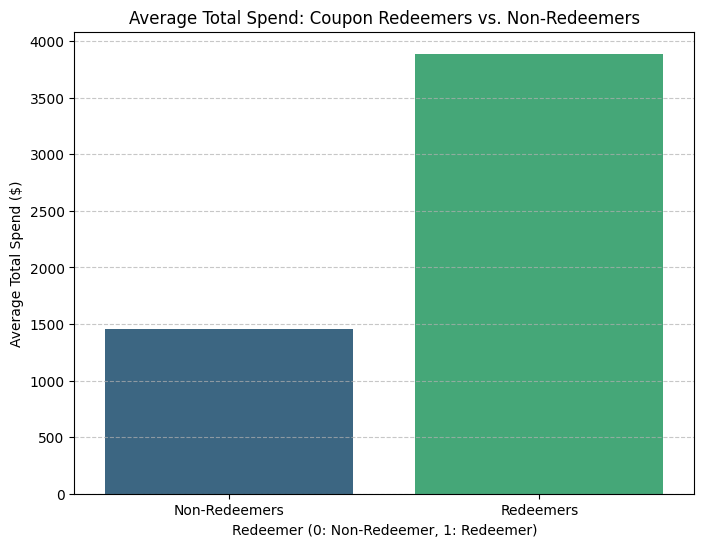

In [7]:
# Redeemers vs non-redeemers average total spend
q1_summary = (
    analysis_df.groupby("redeemer", as_index=False)
    .agg(avg_total_spend=("total_spend", "mean"))
)

plt.figure(figsize=(8, 6))
sns.barplot(x="redeemer", y="avg_total_spend", data=q1_summary, palette="viridis")
plt.title("Average Total Spend: Coupon Redeemers vs. Non-Redeemers")
plt.xlabel("Redeemer (0: Non-Redeemer, 1: Redeemer)")
plt.ylabel("Average Total Spend ($)")
plt.xticks(ticks=[0, 1], labels=["Non-Redeemers", "Redeemers"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

The chart compares average total spend between coupon redeemers and non‑redeemers, showing whether redeemers are higher‑value customers in this dataset. If redeemers spend more, promotions are aligned with higher‑spend behavior and should be continued, but targeted to maximize value. If redeemers spend less, promotions may be attracting lower‑value customers and should be tightened to focus on higher‑value segments. Because this is associative (not causal), use the result to guide targeting, not to claim impact.

### **Q2: Which demographic segments (age, income, kids) have the highest spend among coupon redeemers?**

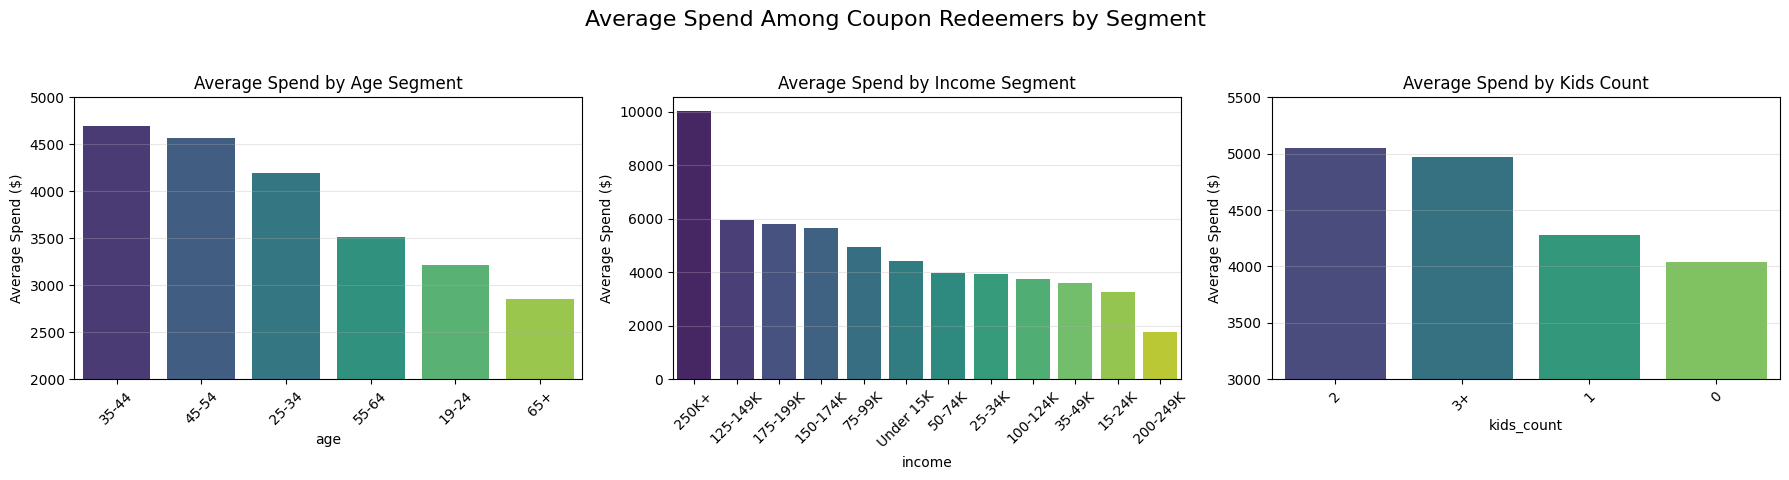

In [8]:
redeemers = analysis_df[analysis_df["redeemer"] == 1].copy()

age_avg = redeemers.groupby("age")["total_spend"].mean().sort_values(ascending=False)
income_avg = redeemers.groupby("income")["total_spend"].mean().sort_values(ascending=False)
kids_count_avg = redeemers.groupby("kids_count")["total_spend"].mean().sort_values(ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Average Spend Among Coupon Redeemers by Segment", fontsize=16)

# Average Spend by Age Segment

sns.barplot(x=age_avg.index, y=age_avg.values, palette="viridis", ax=axes[0])
axes[0].set_title("Average Spend by Age Segment")
axes[0].set_ylabel("Average Spend ($)")
axes[0].set_ylim(2000, 5000)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis="y", alpha=0.3)

# Average Spend by Income Segment

sns.barplot(x=income_avg.index, y=income_avg.values, palette="viridis", ax=axes[1])
axes[1].set_title("Average Spend by Income Segment")
axes[1].set_ylabel("Average Spend ($)")
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis="y", alpha=0.3)

# Average Spend by Kid Count

sns.barplot(x=kids_count_avg.index, y=kids_count_avg.values, palette="viridis", ax=axes[2])
axes[2].set_title("Average Spend by Kids Count")
axes[2].set_ylabel("Average Spend ($)")
axes[2].set_ylim(3000, 5500)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis="y", alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### **Q2a: Which of these customer segments are most likely to redeem coupons?**

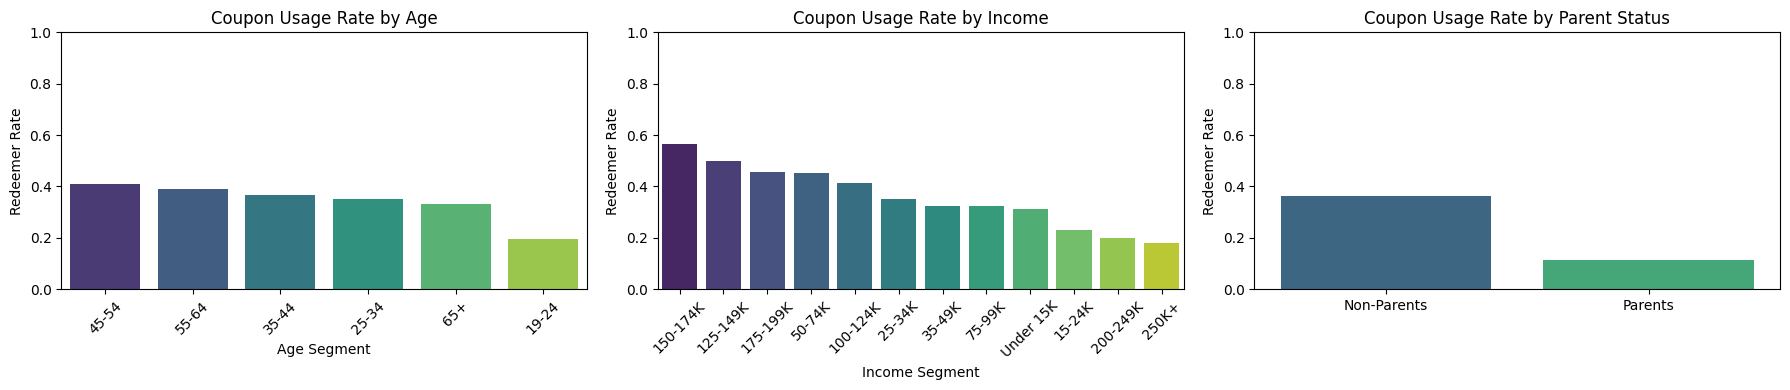

In [9]:
# Coupon usage rate by segment (age, income, parent/non-parent)

def usage_rate(df, col):
    tmp = (
        df.groupby(col)
        .agg(households=("household_id", "nunique"), redeemers=("redeemer", "sum"))
        .reset_index()
    )
    tmp["redeemer_rate"] = tmp["redeemers"] / tmp["households"]
    return tmp.sort_values("redeemer_rate", ascending=False)

# Parent vs non-parent flag
analysis_df["parent_flag"] = np.where(
    analysis_df["kids_count"].astype(str) != "0",
    "Parents",
    "Non-Parents"
)

age_rate = usage_rate(analysis_df, "age")
income_rate = usage_rate(analysis_df, "income")
parent_rate = usage_rate(analysis_df, "parent_flag")

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.barplot(x="age", y="redeemer_rate", data=age_rate, palette="viridis", ax=axes[0])
axes[0].set_title("Coupon Usage Rate by Age")
axes[0].set_xlabel("Age Segment")
axes[0].set_ylabel("Redeemer Rate")
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(x="income", y="redeemer_rate", data=income_rate, palette="viridis", ax=axes[1])
axes[1].set_title("Coupon Usage Rate by Income")
axes[1].set_xlabel("Income Segment")
axes[1].set_ylabel("Redeemer Rate")
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='x', rotation=45)

sns.barplot(x="parent_flag", y="redeemer_rate", data=parent_rate, palette="viridis", ax=axes[2])
axes[2].set_title("Coupon Usage Rate by Parent Status")
axes[2].set_xlabel("")
axes[2].set_ylabel("Redeemer Rate")
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()


### **Q3: Which demographic segments have the highest net spend and ROI proxy among coupon redeemers?**

In [10]:
# --- Q3: Segment performance among coupon redeemers ---

# 1 Filter to coupon redeemers only
redeemers_df = analysis_df[analysis_df["redeemer"] == 1].copy()

# 2️ Choose demographic segment to analyze
# (Change this variable to test others: age, household_size, kids_count, etc.)
segment_var = "income"

# 3️ Compute segment-level metrics
segment_summary = (
    redeemers_df.groupby(segment_var, dropna=False)
    .agg(
        avg_net_spend=("total_net_spend", "mean"),
        avg_roi_proxy=("roi_proxy", "mean"),
        household_count=("household_id", "count")
    )
)

# 4️ Rank segments
top_net_spend = segment_summary.sort_values(
    "avg_net_spend", ascending=False
).head(5)

top_roi_proxy = segment_summary.sort_values(
    "avg_roi_proxy", ascending=False
).head(5)

# 5️ Output
print("Top 5 Segments by Net Spend:")
display(top_net_spend)

print("\nTop 5 Segments by ROI Proxy:")
display(top_roi_proxy)

Top 5 Segments by Net Spend:


,avg_net_spend,avg_roi_proxy,household_count
income,,,
250K+,8634.830000,6.229952,2
125-149K,5066.606316,5.896536,19
175-199K,5025.504000,6.558079,5
150-174K,4825.176471,6.255630,17
75-99K,4055.860323,5.282519,31



Top 5 Segments by ROI Proxy:


,avg_net_spend,avg_roi_proxy,household_count
income,,,
175-199K,5025.504000,6.558079,5
150-174K,4825.176471,6.255630,17
250K+,8634.830000,6.229952,2
125-149K,5066.606316,5.896536,19
75-99K,4055.860323,5.282519,31


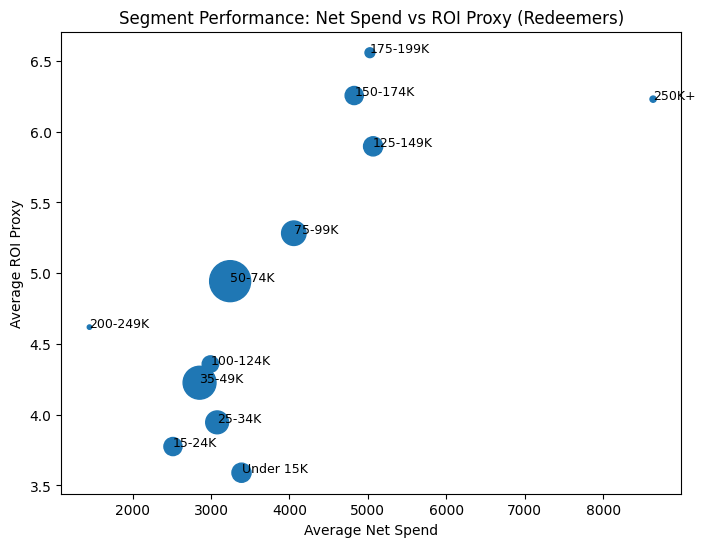

In [11]:
# Prepare segment summary (reuse from Q3)
segment_var = "income"

segment_summary = (
    analysis_df[analysis_df["redeemer"] == 1]
    .groupby(segment_var)
    .agg(
        avg_net_spend=("total_net_spend", "mean"),
        avg_roi_proxy=("roi_proxy", "mean"),
        household_count=("household_id", "count")
    )
    .reset_index()
)

# Scatter plot
plt.figure(figsize=(8, 6))

plt.scatter(
    segment_summary["avg_net_spend"],
    segment_summary["avg_roi_proxy"],
    s=segment_summary["household_count"] * 10,  # bubble size
)

# Label each point with segment name
for _, row in segment_summary.iterrows():
    plt.text(
        row["avg_net_spend"],
        row["avg_roi_proxy"],
        row[segment_var],
        fontsize=9
    )

plt.xlabel("Average Net Spend")
plt.ylabel("Average ROI Proxy")
plt.title("Segment Performance: Net Spend vs ROI Proxy (Redeemers)")
plt.show()

### **Q4: Among coupon redeemers, is higher spend associated more with more shopping trips or larger basket size?**

In [12]:
# Among coupon redeemers, is higher spend associated more with more trips or larger basket size?

redeemers = analysis_df[analysis_df["redeemer"] == 1].copy()

# Guard against divide by zero
redeemers["avg_basket_spend"] = np.where(
    redeemers["total_trips"] > 0,
    redeemers["total_spend"] / redeemers["total_trips"],
    np.nan
)

# Split redeemers into spend groups (top vs bottom 25%)
low_q = redeemers["total_spend"].quantile(0.25)
high_q = redeemers["total_spend"].quantile(0.75)

low_spend = redeemers[redeemers["total_spend"] <= low_q]
high_spend = redeemers[redeemers["total_spend"] >= high_q]

summary = pd.DataFrame({
    "group": ["Low Spend (bottom 25%)", "High Spend (top 25%)"],
    "avg_trips": [low_spend["total_trips"].mean(), high_spend["total_trips"].mean()],
    "avg_basket_spend": [low_spend["avg_basket_spend"].mean(), high_spend["avg_basket_spend"].mean()]
})

summary


,group,avg_trips,avg_basket_spend
0,Low Spend (bottom 25%),67.038835,28.915927
1,High Spend (top 25%),173.883495,50.873886


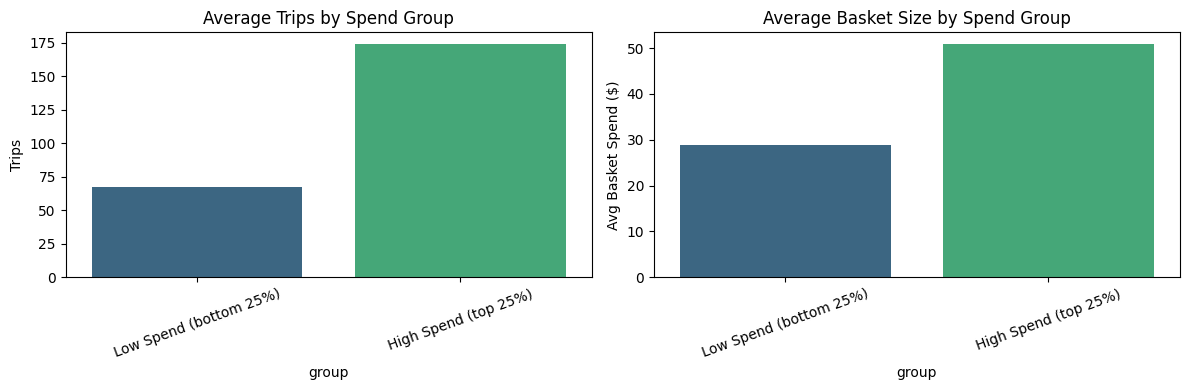

In [13]:
# Visual comparison: trips vs basket size
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(x="group", y="avg_trips", data=summary, ax=axes[0], palette="viridis")
axes[0].set_title("Average Trips by Spend Group")
axes[0].set_ylabel("Trips")
axes[0].tick_params(axis='x', rotation=20)

sns.barplot(x="group", y="avg_basket_spend", data=summary, ax=axes[1], palette="viridis")
axes[1].set_title("Average Basket Size by Spend Group")
axes[1].set_ylabel("Avg Basket Spend ($)")
axes[1].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()


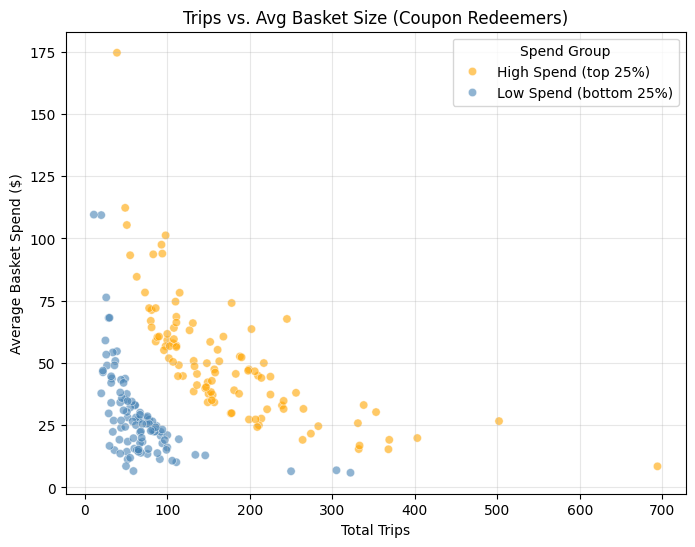

In [14]:
# Scatter Chart: trips vs basket size, colored by spend group
redeemers = analysis_df[analysis_df["redeemer"] == 1].copy()

redeemers["avg_basket_spend"] = np.where(
    redeemers["total_trips"] > 0,
    redeemers["total_spend"] / redeemers["total_trips"],
    np.nan
)

low_q = redeemers["total_spend"].quantile(0.25)
high_q = redeemers["total_spend"].quantile(0.75)

def spend_group(x):
    if x <= low_q:
        return "Low Spend (bottom 25%)"
    if x >= high_q:
        return "High Spend (top 25%)"
    return "Middle 50%"

redeemers["spend_group"] = redeemers["total_spend"].apply(spend_group)

# Plot only low/high
plot_df = redeemers[redeemers["spend_group"] != "Middle 50%"].dropna(subset=["avg_basket_spend"])

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=plot_df,
    x="total_trips",
    y="avg_basket_spend",
    hue="spend_group",
    palette={"Low Spend (bottom 25%)": "steelblue", "High Spend (top 25%)": "orange"},
    alpha=0.6
)
plt.title("Trips vs. Avg Basket Size (Coupon Redeemers)")
plt.xlabel("Total Trips")
plt.ylabel("Average Basket Spend ($)")
plt.legend(title="Spend Group")
plt.grid(alpha=0.3)
plt.show()


This scatter shows how coupon redeemers generate spend: higher spenders cluster at both higher trip counts and higher basket size. The separation between the high‑spend and low‑spend groups indicates that frequency is a major driver, with basket size also contributing. Actionably, prioritize promotions that increase trip frequency for mid/low spenders, while using targeted basket‑building offers (bundles, thresholds) for already active shoppers. This suggests a promotion strategy of driving more visits for lower spenders and larger baskets for higher spenders.

### **Q5: Are heavy coupon redeemers less efficient than moderate redeemers?**

In [15]:
# Are heavy coupon redeemers less efficient than moderate redeemers?

# Use only redeemers
redeemers = analysis_df[analysis_df["redeemer"] == 1].copy()

# Create redemption tiers based on redemption_count
# Low/Medium/High levels among redeemers
t1, t2 = redeemers["redemption_count"].quantile([1/3, 2/3]).values

def tier(x):
    if x <= t1:
        return "Low"
    elif x <= t2:
        return "Medium"
    return "High"

redeemers["redeem_tier"] = redeemers["redemption_count"].apply(tier)

# Summary table
q5_summary = (
    redeemers.groupby("redeem_tier", as_index=False)
    .agg(
        households=("household_id", "nunique"),
        avg_spend=("total_spend", "mean"),
        avg_net_spend=("total_net_spend", "mean"),
        avg_discount=("total_discount", "mean"),
        avg_roi_proxy=("roi_proxy", "mean")
    )
)

# Order tiers
tier_order = ["Low", "Medium", "High"]
q5_summary["redeem_tier"] = pd.Categorical(q5_summary["redeem_tier"], categories=tier_order, ordered=True)
q5_summary = q5_summary.sort_values("redeem_tier")


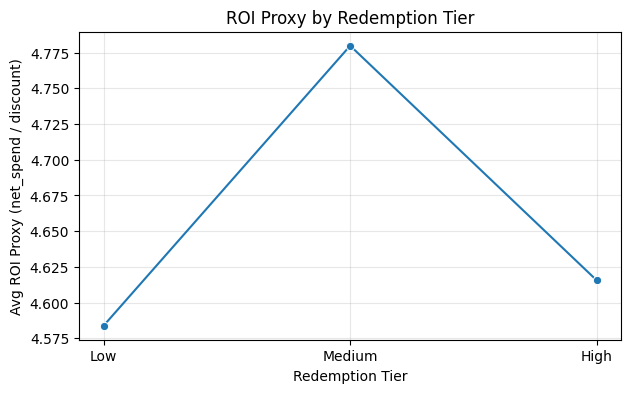

In [16]:
# Plot efficiency (ROI proxy) by tier
plt.figure(figsize=(7, 4))
sns.lineplot(data=q5_summary, x="redeem_tier", y="avg_roi_proxy", marker="o")
plt.title("ROI Proxy by Redemption Tier")
plt.xlabel("Redemption Tier")
plt.ylabel("Avg ROI Proxy (net_spend / discount)")
plt.grid(alpha=0.3)
plt.show()


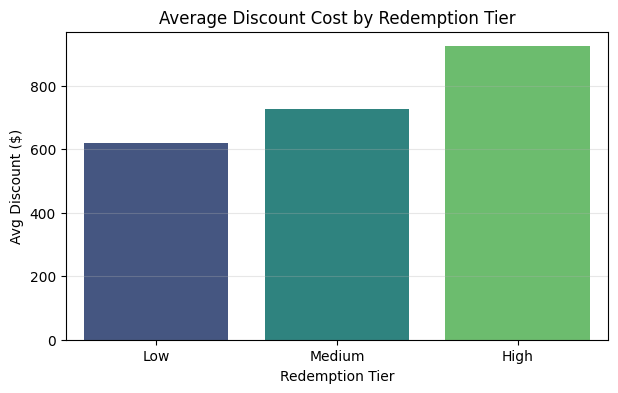

In [17]:
# Plot average discount cost by tier
plt.figure(figsize=(7, 4))
sns.barplot(data=q5_summary, x="redeem_tier", y="avg_discount", palette="viridis")
plt.title("Average Discount Cost by Redemption Tier")
plt.xlabel("Redemption Tier")
plt.ylabel("Avg Discount ($)")
plt.grid(axis="y", alpha=0.3)
plt.show()


These charts show that heavier coupon redeemers drive higher discount costs, and their efficiency is measured by the ROI proxy line. If ROI proxy declines from Medium to High, it indicates diminishing returns: heavy redeemers consume more discounts without proportional net value. Actionably, cap coupon frequency or value for high-tier redeemers and redirect offers toward medium-tier customers who deliver stronger net value per discount dollar. If ROI proxy stays flat or rises, heavier redeemers remain efficient and can be prioritized for retention‑focused promotions.




## **Conclusion/Findings:**